In [1]:
from q_lib import Q_learner
from WoLF_lib import WoLF_PHC
from JAL_AM_lib import JAL_AM, edge_or_focal
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm import tqdm

# Average profitability

## Baseline

In [11]:
def run_sim( alpha, gamma, delta_l, delta_w, k, T, n):#(0.3,0.95,0.2,0.6,np.linspace(0,1,7),500000,100)
    """
    args:
        alpha: step-size parameter
        gamma: discount factor
        delta_l:
        delta_w:
        k: length of price action vector
        T: number of total simulations
        n: number of runs simulated
    returns:
        JAL_AM_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for JAL-AM
        Q_learner_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for Q-learning
        WoLF_PHC_res: list conating avg. profitabilities, avg. profit gain, counter for both edgeworth price cycles and focal pricing for WoLF-PHC
    """
    num_calcs=int(T/1000-1) # size of avg. profits 

    #JAL-AM
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    focal = 0
    edge = 0

    for i in tqdm(range(n), desc='JAL-AM 1/3', leave=True):
        p_table, avg_profs1, avg_profs2 = JAL_AM(alpha, gamma, T, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        avg_prof_gain[i] = per_firm_profit[498]/0.125
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        edge, focal, p_m = edge_or_focal(edge, focal, p_table)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    JAL_AM_res=[avg_avg_profitabilities, avg_prof_gain, edge, focal]
    avg_avg_profitabilities=0

    #Q-learning
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    focal = 0
    edge = 0
    # simulating n runs of Klein_simulation
    for i in tqdm(range(n), desc='Q-learning 2/3', leave=True):
        p_table, avg_profs1, avg_profs2 = Q_learner(alpha, gamma, T, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        avg_prof_gain[i] = per_firm_profit[498]/0.125
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        edge, focal, p_m = edge_or_focal(edge, focal, p_table)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    Q_learner_res=[avg_avg_profitabilities, avg_prof_gain, edge, focal]
    avg_avg_profitabilities=0

    #WoLF-PHC
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    focal = 0
    edge = 0
    # simulating n runs of Klein_simulation avg_profs1, avg_profs2, p_table, policy_1, policy_2
    for i in tqdm(range(n), desc='WoLF-PHC 3/3', leave=True):# (0.3, 0.6, 0.2, 0.95, np.linspace(0,1,49), 500000)
        avg_profs1, avg_profs2, p_table, = WoLF_PHC(alpha, delta_l, delta_w, gamma, k, T)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        avg_prof_gain[i] = per_firm_profit[498]/0.125
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        edge, focal, p_m = edge_or_focal(edge, focal, p_table)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    WoLF_PHC_res=[avg_avg_profitabilities, avg_prof_gain, edge, focal]
    return JAL_AM_res,Q_learner_res, WoLF_PHC_res, n, len(k)

In [55]:
JAL_AM_res,Q_learner_res, WoLF_PHC_res, t, k=run_sim(0.3,0.95,0.2,0.6,np.linspace(0,1,7),500000,1000)

WoLF-PHC 3/3: 100%|██████████| 1000/1000 [36:17<00:00,  2.18s/it]


In [ ]:
JAL_AM_res24,Q_learner_res24, WoLF_PHC_res24, tt, k24=run_sim(0.3,0.95,0.2,0.6,np.linspace(0,1,25),500000,1000)

### Profitability graph

In [79]:
def plot_profitability(t, k, JAL_AM_res, Q_learner_res, WoLF_PHC_res):
    fig, axs = plt.subplots(1, 1, figsize=(10,7))
    fig.suptitle("Average profitability for all in {} different runs, k={}".format(t, k-1))
    axs.set_xlabel("t")
    axs.set_ylabel("profitability")
    xs = np.linspace(0, 500000, 499)
    axs.set_ylim(0.05,0.125+(0.125*0.05))
    axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='black', linestyles='dashed', label='Joint profit maximizing')
    axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='grey', linestyles='dashed', label='Comp Benchmark')
    axs.plot(xs, JAL_AM_res[0], color="steelblue", label = "JAL-AM")
    axs.plot(xs, Q_learner_res[0], color="C3", label = "Q-learning")
    axs.plot(xs, WoLF_PHC_res[0], color="g", label = "WoLF-PHC")


    axs.legend()  # Show the legend to display the label of the newly added line
    plt.savefig('Graphs/baseline_prof.png')
    plt.show()

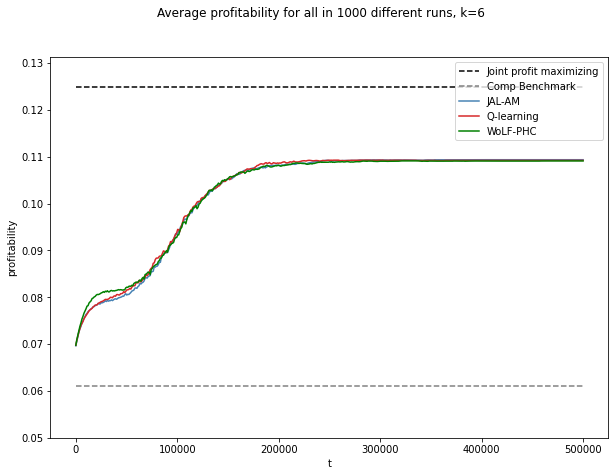

In [80]:
plot_profitability(t, k, JAL_AM_res, Q_learner_res, WoLF_PHC_res)


In [57]:
JAL_AM_res[0][498]

0.10937697222222381

In [58]:
Q_learner_res[0][498]

0.10923280555555691

In [59]:
WoLF_PHC_res[0][498]

0.10911644444444589

### Avg. profit gain graph

In [60]:
# Function to count values in each interval
def count_intervals(data, intervals):
    counts = np.zeros(len(intervals), dtype=int)
    for num in data:
        for i, interval in enumerate(intervals):
            if interval[0] <= num < interval[1]:
                counts[i] += 1
    return counts

In [71]:
def plot_avg_prof_gain(data1, data2, intervals, labels, algo, k_val):
    # Plot the counts for each interval for JAL_AM_res
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(intervals))
    bar1 = plt.bar(index - bar_width/2, data1, bar_width, label= f'k={k_val[0]}')
    bar2 = plt.bar(index + bar_width/2, data2, bar_width, label=f'k={k_val[1]}')
    
    plt.xticks(index, labels, rotation=45, ha='right')
    plt.xlabel('Δ')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Avg. Profit Gain for {algo}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Sub Directory/avg_prof_gain_{algo}.png')
    plt.show()

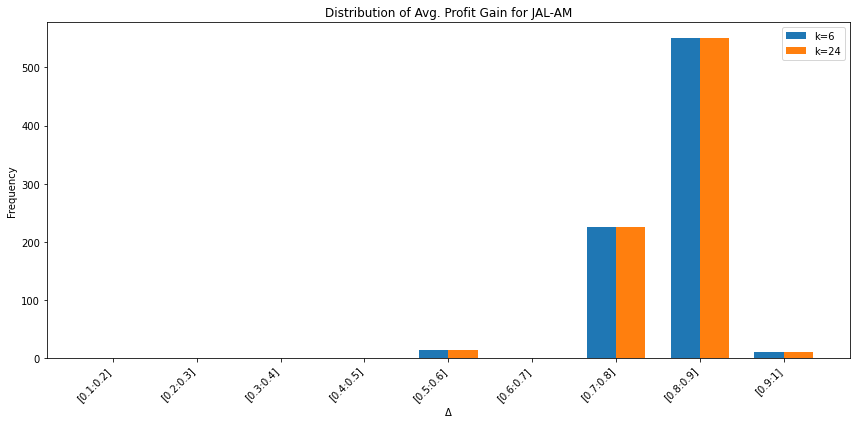

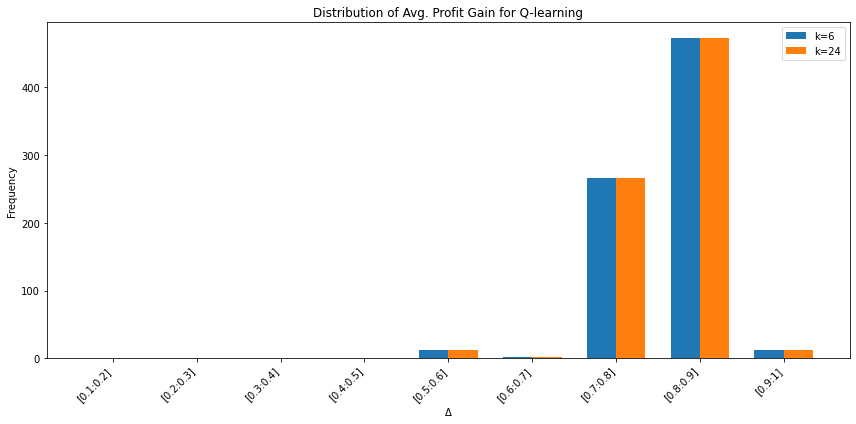

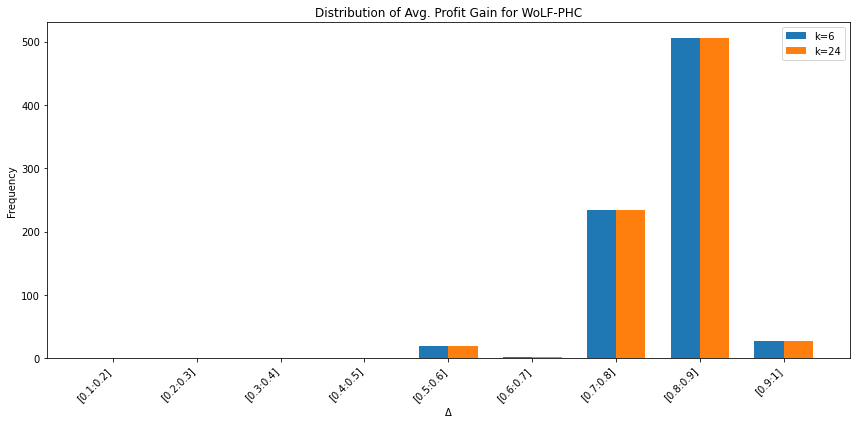

In [74]:
# Define the intervals
intervals = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0.1:0.2]','[0.2:0.3]', '[0.3:0.4]', '[0.4:0.5]', '[0.5:0.6]', '[0.6:0.7]', '[0.7:0.8]', '[0.8:0.9]', '[0.9:1]']

JAL_AM_prof_gain_k6 = count_intervals(JAL_AM_res[1], intervals)
JAL_AM_prof_gain_k24 = count_intervals(JAL_AM_res[1], intervals)
plot_avg_prof_gain(JAL_AM_prof_gain_k6, JAL_AM_prof_gain_k24, intervals, intervals_str, 'JAL-AM', [6, 24])

Q_prof_gain_k6 = count_intervals(Q_learner_res[1], intervals)
Q_prof_gain_k24 = count_intervals(Q_learner_res[1], intervals)
plot_avg_prof_gain(Q_prof_gain_k6, Q_prof_gain_k24, intervals, intervals_str, 'Q-learning', [6, 24])


WoLF_PHC_prof_gain_k6 = count_intervals(WoLF_PHC_res[1], intervals)
WoLF_PHC_prof_gain_k24 = count_intervals(WoLF_PHC_res[1], intervals)
plot_avg_prof_gain(WoLF_PHC_prof_gain_k6, WoLF_PHC_prof_gain_k24, intervals, intervals_str, 'WoLF-PHC', [6, 24])



### Edgeworth price cycles & focal pricing

In [87]:
def plot_edge_focal(edgeworth_data, focal_data, k):
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Define the positions for the groups
    index = np.arange(2)  # We have two categories
    bar_width = 0.2  # Width of each bar
    # Define the positions for each bar in the group
    positions_JAL_AM = index - bar_width
    positions_Q = index
    positions_WoLF_PHC = index + bar_width
    # Plotting
    bar1 = ax.bar(positions_JAL_AM[0], edgeworth_data[0], bar_width, label='JAL-AM', color='steelblue')
    bar2 = ax.bar(positions_Q[0], edgeworth_data[1], bar_width, label='Q-learning', color='C3')
    bar3 = ax.bar(positions_WoLF_PHC[0], edgeworth_data[2], bar_width, label='WoLF-PHC', color='g')

    bar4 = ax.bar(positions_JAL_AM[1], focal_data[0], bar_width, label='JAL-AM',color='steelblue')
    bar5 = ax.bar(positions_Q[1], focal_data[1], bar_width, label='Q-learning', color='C3')
    bar6 = ax.bar(positions_WoLF_PHC[1], focal_data[2], bar_width, label='WoLF-PHC', color='g')

    # Labels and title
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Edgeworth Price Cycles and Focal Pricing, k={k}')
    ax.set_xticks(index)
    ax.set_xticklabels(['Edgeworth Price Cycles', 'Focal Pricing'])
    ax.legend(['JAL-AM', 'Q-learning', 'WoLF-PHC'])

    # Display the plot
    plt.tight_layout()
    plt.savefig(f'Graphs/edgeworth_focal_k{k}.png')
    plt.show()

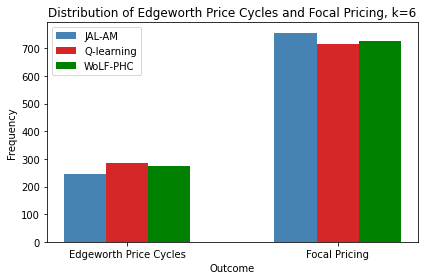

In [88]:
edgeworth_data = [JAL_AM_res[2], Q_learner_res[2], WoLF_PHC_res[2]]
focal_data = [JAL_AM_res[3], Q_learner_res[3], WoLF_PHC_res[3]]

plot_edge_focal(edgeworth_data, focal_data, 6)

## Asymmetric information

# Average profit gain

## Baseline

## Asymmetric information

# Edgeworth cycles

## Baseline

## Asymmetric information